# Dataset length check 

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
foodon_data_path = Path.cwd().parent / "foodon" / "data" / "semantic" / "food_on_filtered_subsumption_dataset.pkl"
helis_data_path = Path.cwd().parent / "helis" / "data" / "semantic" / "helis_filtered_subsumption_dataset.pkl"

with open(foodon_data_path, "rb") as f:
    foodon_data = pickle.load(f)
with open(helis_data_path, "rb") as f:
    helis_data = pickle.load(f)

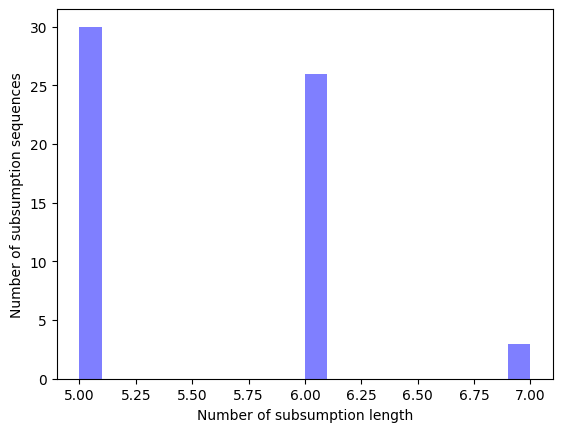

In [2]:
list_map = lambda f, l: list(map(f, l))
# plt.hist(list_map(len, foodon_data), bins=20, alpha = 0.5, color='r')
plt.hist(list_map(len, helis_data), bins=20, alpha = 0.5, color='b', histtype = 'bar')
plt.xlabel("Number of subsumption length")
plt.ylabel("Number of subsumption sequences")
plt.show()


# [Sensitivity analysis of the Semantic Metric with respect to vectors’ dimension](https://arxiv.org/pdf/2407.08623)

## generate uniform rank from random distribution (compair to sequence order as ground truth) then compute then metric 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from numba import njit

# set random seed for reproducibility
np.random.seed(42)
# Semantic-aligned Mean Rank (SMR)
@njit(fastmath=True)
def sem_to_sequence(
        proposed_sequence: np.ndarray,
        true_R: int,
    ) -> float:
    """
    proposed_sequence: list of str
    true_sequence: list of str
    """
    
    semmr: float = 0.0
    semmrr: float = 0.0
    pow2 = 1.0
    for true_rank in proposed_sequence[:true_R][::-1]:
        semmr += (true_rank + 1) * pow2
        semmrr += pow2 / (true_rank + 1)
        pow2 *= 2.0
    return semmr, semmrr

## Variance in proposed sequence dimension size

In [6]:
# generate random data for n
n = 1e4
dims = np.arange(1, 30, 1)

all_dim_semr, all_dim_semmrr = np.empty((len(dims), int(n))), np.empty((len(dims), int(n)))
for i, dim in enumerate(tqdm(dims)):
    data = np.array([np.random.choice(dim, dim, replace = False) for _ in range(int(n))])
    for j, dat in enumerate(data):

        semr, semmrr = sem_to_sequence(proposed_sequence = dat, true_R = dim)
        all_dim_semr[i, j] = semr
        all_dim_semmrr[i, j] = semmrr
        
        
all_dim_semr_bound, all_dim_semmrr_bound = np.empty((len(dims), 2)), np.empty((len(dims), 2))
for i, dim in enumerate(dims):
    gt = np.arange(dim)
    worse = gt[::-1]
    semr_gt, semmrr_gt = sem_to_sequence(proposed_sequence = gt, true_R = dim)
    semr_worse, semmrr_worse = sem_to_sequence(proposed_sequence = worse, true_R = dim)
    
    all_dim_semr_bound[i] = [semr_gt, semr_worse]
    all_dim_semmrr_bound[i] = [semmrr_gt, semmrr_worse]

100%|██████████| 29/29 [00:03<00:00,  8.16it/s]


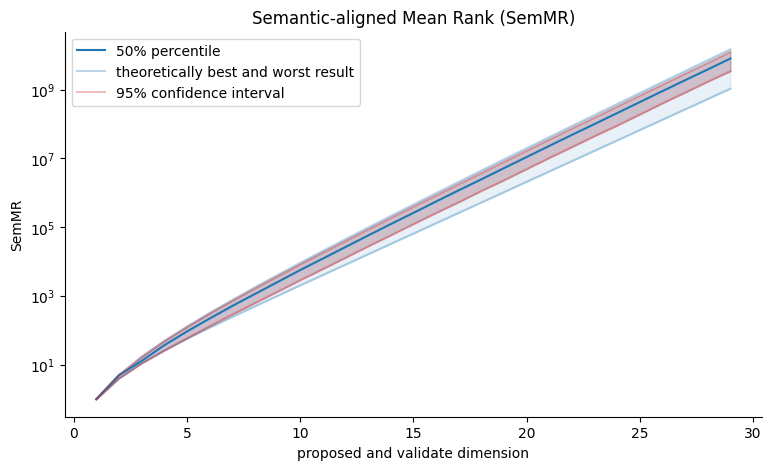

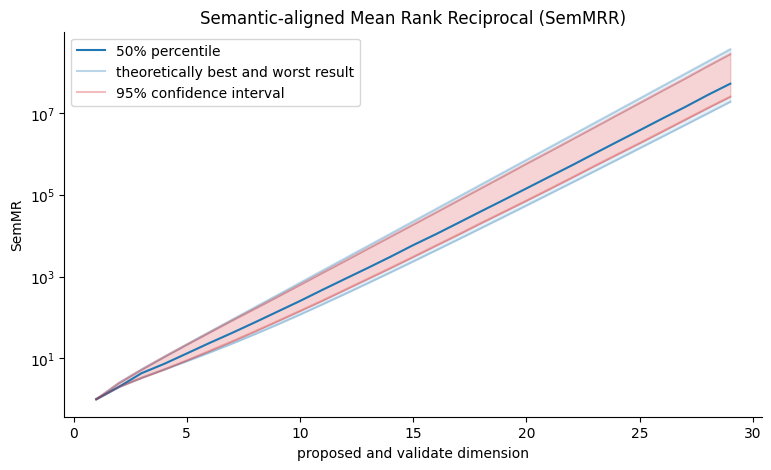

In [7]:
def plot_random_metric(sampling, bound, title):
    df = pd.DataFrame(np.percentile(sampling, [2.5, 50, 97.5], axis=1), index = ['2.5%', '50%', '97.5%'], columns=dims).T

    # best and worst case
    df["upper"] = bound[:, 0]
    df["lower"] = bound[:, 1]


    fig, ax = plt.subplots(figsize=(9,5))
    ax.set_yscale('log')
    ax.plot(dims, df['50%'], label='50% percentile', color='tab:blue')

    ax.plot(dims, df["lower"] , color='tab:blue', alpha=0.3, label='theoretically best and worst result')
    ax.plot(dims, df["upper"] , color='tab:blue', alpha=0.3)

    ax.plot(dims, df['2.5%'] , color='tab:red', alpha=0.3, label=r'95% confidence interval')
    ax.plot(dims, df['97.5%'] , color='tab:red', alpha=0.3)

    ax.fill_between(dims, df["lower"] , df['2.5%'], alpha=0.1, color='tab:blue')
    ax.fill_between(dims, df['2.5%'] , df['97.5%'], alpha=0.2, color='tab:red')
    ax.fill_between(dims, df['97.5%'] , df["upper"], alpha=0.1, color='tab:blue')

    plt.legend()
    ax.set_xlabel('proposed and validate dimension')
    ax.set_ylabel('SemMR')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(title)
    plt.show()
    
plot_random_metric(all_dim_semr, all_dim_semr_bound, title = 'Semantic-aligned Mean Rank (SemMR)')
plot_random_metric(all_dim_semmrr, all_dim_semmrr_bound, title = 'Semantic-aligned Mean Rank Reciprocal (SemMRR)')

## Variance in ground truth dimension size

In [21]:
## fix the dimension size of proposed sequence to 100
# generate random data for n
n = 1e4
proposed_dim = 100
dims = np.arange(1, 30, 1)

all_dim_semr, all_dim_semmrr = np.empty((len(dims), int(n))), np.empty((len(dims), int(n)))
for i, dim in enumerate(tqdm(dims)):
    data = np.array([np.random.choice(proposed_dim, proposed_dim, replace = False) for _ in range(int(n))])
    for j, dat in enumerate(data):
        semr, semmrr = sem_to_sequence(proposed_sequence = dat, true_R = dim)
        all_dim_semr[i, j] = semr
        all_dim_semmrr[i, j] = semmrr
        
        
all_dim_semr_bound, all_dim_semmrr_bound = np.empty((len(dims), 2)), np.empty((len(dims), 2))
gt = np.arange(proposed_dim)
worse = gt[::-1]
for i, dim in enumerate(dims):
    semr_gt, semmrr_gt = sem_to_sequence(proposed_sequence = gt, true_R = dim)
    semr_worse, semmrr_worse = sem_to_sequence(proposed_sequence = worse, true_R = dim)
    
    all_dim_semr_bound[i] = [semr_gt, semr_worse]
    all_dim_semmrr_bound[i] = [semmrr_gt, semmrr_worse]

100%|██████████| 29/29 [00:03<00:00,  7.66it/s]


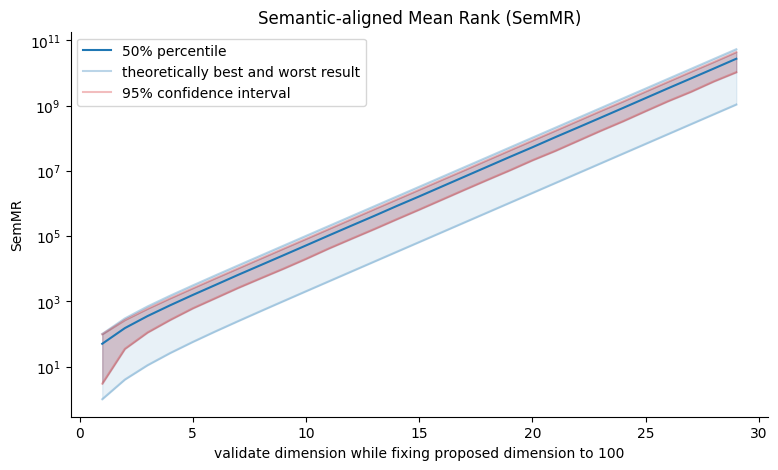

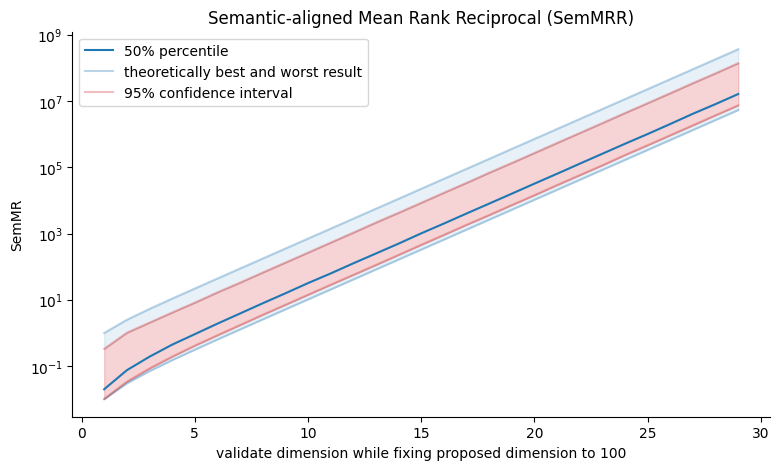

In [22]:
def plot_random_metric(sampling, bound, title):
    df = pd.DataFrame(np.percentile(sampling, [2.5, 50, 97.5], axis=1), index = ['2.5%', '50%', '97.5%'], columns=dims).T

    # best and worst case
    df["upper"] = bound[:, 0]
    df["lower"] = bound[:, 1]


    fig, ax = plt.subplots(figsize=(9,5))
    ax.set_yscale('log')
    ax.plot(dims, df['50%'], label='50% percentile', color='tab:blue')

    ax.plot(dims, df["lower"] , color='tab:blue', alpha=0.3, label='theoretically best and worst result')
    ax.plot(dims, df["upper"] , color='tab:blue', alpha=0.3)

    ax.plot(dims, df['2.5%'] , color='tab:red', alpha=0.3, label=r'95% confidence interval')
    ax.plot(dims, df['97.5%'] , color='tab:red', alpha=0.3)

    ax.fill_between(dims, df["lower"] , df['2.5%'], alpha=0.1, color='tab:blue')
    ax.fill_between(dims, df['2.5%'] , df['97.5%'], alpha=0.2, color='tab:red')
    ax.fill_between(dims, df['97.5%'] , df["upper"], alpha=0.1, color='tab:blue')

    plt.legend()
    ax.set_xlabel(f'validate dimension while fixing proposed dimension to {proposed_dim}')
    ax.set_ylabel('SemMR')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(title)
    plt.show()
    

plot_random_metric(all_dim_semr, all_dim_semr_bound, title = 'Semantic-aligned Mean Rank (SemMR)')
plot_random_metric(all_dim_semmrr, all_dim_semmrr_bound, title = 'Semantic-aligned Mean Rank Reciprocal (SemMRR)')

In [ ]:
def plot_random_metric(sampling, bound, title):
    df = pd.DataFrame(np.percentile(sampling, [2.5, 50, 97.5], axis=1), index = ['2.5%', '50%', '97.5%'], columns=dims).T

    # best and worst case
    df["upper"] = bound[:, 0]
    df["lower"] = bound[:, 1]


    fig, ax = plt.subplots(figsize=(9,5))
    ax.set_yscale('log')
    ax.plot(dims, df['50%'], label='50% percentile', color='tab:blue')

    ax.plot(dims, df["lower"] , color='tab:blue', alpha=0.3, label='theoretically best and worst case')
    ax.plot(dims, df["upper"] , color='tab:blue', alpha=0.3)

    ax.plot(dims, df['2.5%'] , color='tab:red', alpha=0.3, label=r'95% confidence interval')
    ax.plot(dims, df['97.5%'] , color='tab:red', alpha=0.3)

    ax.fill_between(dims, df["lower"] , df['2.5%'], alpha=0.1, color='tab:blue')
    ax.fill_between(dims, df['2.5%'] , df['97.5%'], alpha=0.2, color='tab:red')
    ax.fill_between(dims, df['97.5%'] , df["upper"], alpha=0.1, color='tab:blue')

    plt.legend()
    ax.set_xlabel(f'validate dimension while fixing proposed dimension to {proposed_dim}')
    ax.set_ylabel('SemMR')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(title)
    plt.show()
    

plot_random_metric(all_dim_semr, all_dim_semr_bound, title = 'Semantic-aligned Mean Rank (SMR)')
plot_random_metric(all_dim_semmrr, all_dim_semmrr_bound, title = 'Semantic-aligned Mean Rank Reciprocal (SMRR)')

## Overall landscape

In [13]:
# generate random data for n
n = 1e4
max_dim = 20
dims = np.arange(1, max_dim + 1, 1)
proposed_dims = np.arange(1, max_dim + 1, 1)

all_dim_semr, all_dim_semmrr = np.empty((max_dim, max_dim, int(n))), np.empty((max_dim, max_dim, int(n)))
for i, proposed_dim in enumerate(tqdm(proposed_dims)):
    data = np.array([np.random.choice(proposed_dim, proposed_dim, replace = False) for _ in range(int(n))])
    for j, dim in enumerate(dims):
        for k, dat in enumerate(data):
            semr, semmrr = sem_to_sequence(proposed_sequence = dat, true_R = dim)
            all_dim_semr[i, j, k] = semr
            all_dim_semmrr[i, j, k] = semmrr
        
        
all_dim_semr_bound, all_dim_semmrr_bound = np.empty((max_dim, max_dim, 2)), np.empty((max_dim, max_dim, 2))
for i, proposed_dim in enumerate(proposed_dims):
    gt = np.arange(proposed_dim)
    worse = gt[::-1]
    for j, dim in enumerate(dims):
        semr_gt, semmrr_gt = sem_to_sequence(proposed_sequence = gt, true_R = dim)
        semr_worse, semmrr_worse = sem_to_sequence(proposed_sequence = worse, true_R = dim)
        
        all_dim_semr_bound[i, j] = [semr_gt, semr_worse]
        all_dim_semmrr_bound[i, j] = [semmrr_gt, semmrr_worse]

100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import LightSource

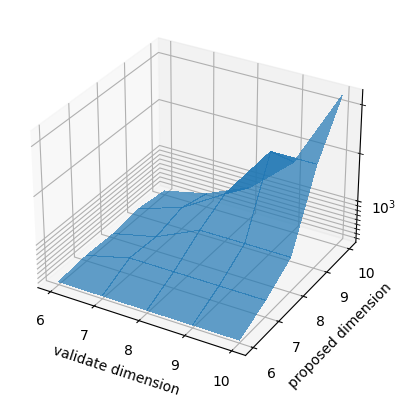

In [15]:

x = dims
y = proposed_dims
z = all_dim_semr[:, :, 0]
x, y = np.meshgrid(x, y)
region = np.s_[5:10, 5:10]
x, y, z = x[region], y[region], z[region]

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1,
                       linewidth=0, antialiased=False, shade=False, alpha=0.7, label = "lower bound")

plt.xlabel('validate dimension')
plt.ylabel('proposed dimension')
ax.set_zlabel('SemMR')

ax.set_zscale('log')
plt.show()

# Normalization